In [115]:
import vectorbt as vbt
import pandas as pd
import numpy as np
import datetime
import yfinance as yf
import matplotlib.pyplot as plt

In [116]:
#pull 10-year data from yfinance library, interval = 1D
end_date = datetime.datetime.now()
start_date = end_date - datetime.timedelta(365*10)

price = vbt.YFData.download(
    'XLF',
    missing_index='drop',
    start = start_date,
    end = end_date,
    interval = '1d').get('Close')

In [118]:
# create custom indicator
def ind(close, fast_window=20, slow_window=200):
    fast_ema = vbt.MA.run(close, window=fast_window, ewm=True).ma
    slow_ema = vbt.MA.run(close, window=slow_window, ewm=True).ma
    
    close = close.to_numpy()
    fast_ema = fast_ema.to_numpy()
    slow_ema = slow_ema.to_numpy()
    
    trend = np.where( (fast_ema > slow_ema), 1, 0 )
    trend = np.where( (fast_ema < slow_ema), -1, trend )
    return trend

In [119]:
# build custom indicator using vbt
ind_signal = vbt.IndicatorFactory(
    input_names = ['close'],
    param_names = ['fast_window', 'slow_window'],
    output_names = ['value']
    ).from_apply_func(
    ind, 
    fast_window=20, 
    slow_window=200, 
    keep_pd=True)

In [120]:
# provide a range of possible EMA combinations to find the optimal pair
res1 = ind_signal.run(
    price,
    fast_window=np.arange(10,60,5),
    slow_window=np.arange(50,230,20),
    param_product=True
    )

In [121]:
# pluging in the optimal pair manually to see portfolio results (plot)
res2 = ind_signal.run(
    price,
    fast_window=40,
    slow_window=70,
    param_product=True
    )

In [122]:
# define entries and exits for optimizing process
entries1 = res1.value == 1
exits1 = res1.value == -1

In [123]:
# define entries and exits for optimal pairs
entries2 = res2.value == 1
exits2 = res2.value == -1

In [124]:
# optimizing portoflio
pf1 = vbt.Portfolio.from_signals(
    close = price,
    entries = entries1,
    exits = exits1,
    init_cash = 10000.0,
    size = 1,
    size_type = 'percent',
    fees = 0.0001,
    freq = 'D'
)

In [125]:
# optimal portfolio
pf2 = vbt.Portfolio.from_signals(
    close = price,
    entries = entries2,
    exits = exits2,
    init_cash = 10000.0,
    size = 1,
    size_type = 'percent',
    fees = 0.0001,
    freq = 'D'
)

In [126]:
returns1 = pf1.total_return()
returns2 = pf2.total_return()

In [132]:
print(returns1)
print(returns2)

custom_fast_window  custom_slow_window
10                  50                    0.583448
                    70                    0.572871
                    90                    0.644735
                    110                   0.748521
                    130                   0.699602
                                            ...   
55                  130                   0.852265
                    150                   0.606625
                    170                   0.551609
                    190                   0.705253
                    210                   0.498589
Name: total_return, Length: 90, dtype: float64
1.5933758773623763


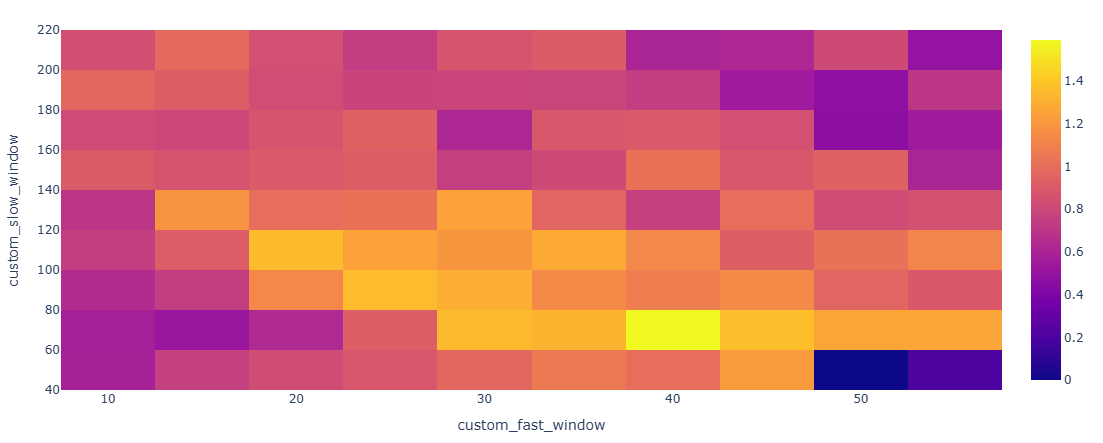

In [128]:
# heatmap to view optimal pair
fig = returns1.vbt.heatmap(
    x_level = 'custom_fast_window',
    y_level = 'custom_slow_window',
)

fig.show()

In [129]:
# optimal pair stats
print(pf2.stats())

Start                         2015-03-27 04:00:00+00:00
End                           2025-03-24 04:00:00+00:00
Period                               2513 days 00:00:00
Start Value                                     10000.0
End Value                                  25933.758774
Total Return [%]                             159.337588
Benchmark Return [%]                         211.369234
Max Gross Exposure [%]                            100.0
Total Fees Paid                               26.042728
Max Drawdown [%]                              21.253344
Max Drawdown Duration                 706 days 00:00:00
Total Trades                                         10
Total Closed Trades                                   9
Total Open Trades                                     1
Open Trade PnL                              8127.884298
Win Rate [%]                                  33.333333
Best Trade [%]                                59.089316
Worst Trade [%]                               -9

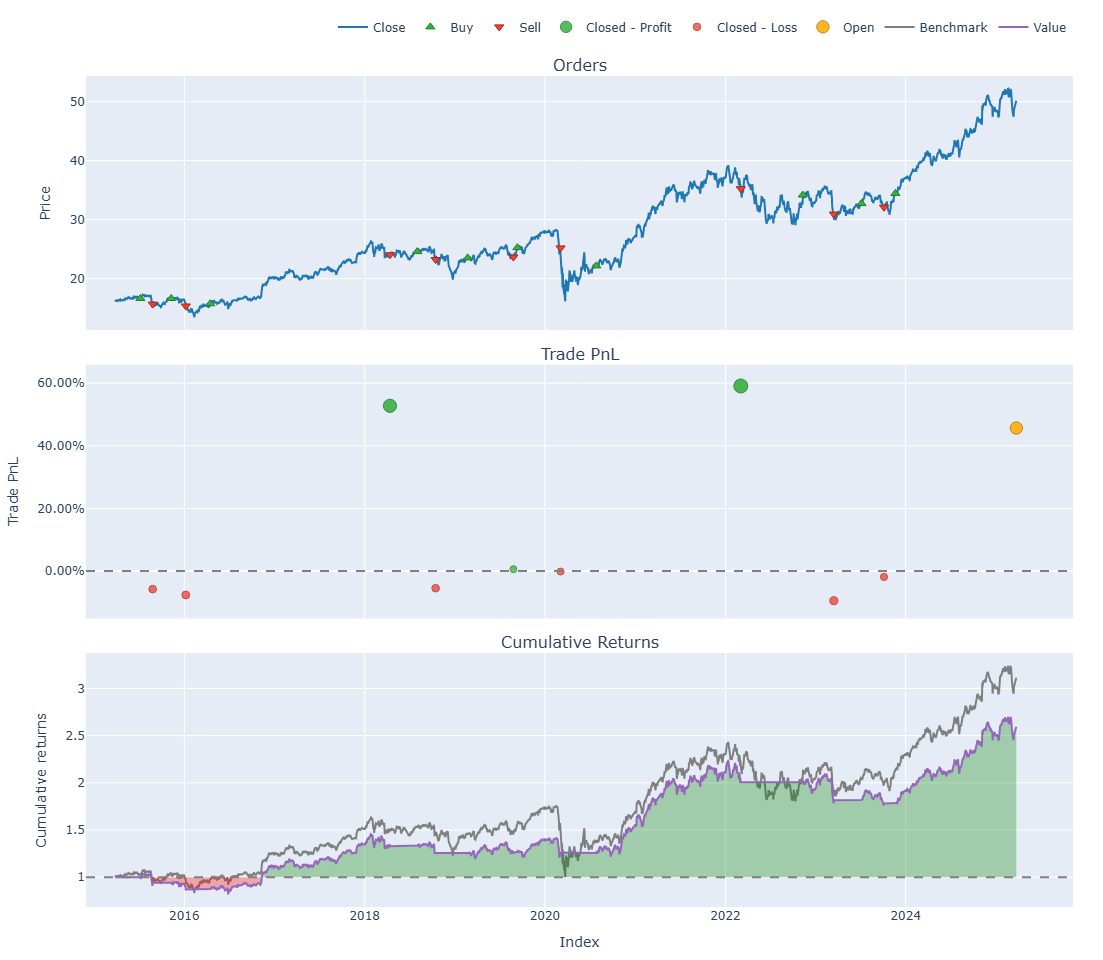

In [130]:
pf2.plot().show()